In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [76]:
df = pd.read_csv('mep_votes_json_final.csv')
df.head()

,mep_id,Position,Party,vote_id,Time_stamp,Procedure_type
0,256810,DID_NOT_VOTE,EPP,176731,2025-05-22T11:38:51,INI
1,257043,FOR,EPP,176731,2025-05-22T11:38:51,INI
2,197490,FOR,EPP,176731,2025-05-22T11:38:51,INI
3,256820,FOR,EPP,176731,2025-05-22T11:38:51,INI
4,256987,AGAINST,Renew,176731,2025-05-22T11:38:51,INI


In [77]:
filtered_df = df[['mep_id', 'Position', 'Party', 'Time_stamp', 'vote_id', 'Procedure_type']]
filtered_df.rename(columns={'Position': 'position', 'Party' : 'party', 'Time_stamp' : 'timestamp', 'Procedure_type' : 'procedure_type'}, inplace=True)
filtered_df.head()

,mep_id,position,party,timestamp,vote_id,procedure_type
0,256810,DID_NOT_VOTE,EPP,2025-05-22T11:38:51,176731,INI
1,257043,FOR,EPP,2025-05-22T11:38:51,176731,INI
2,197490,FOR,EPP,2025-05-22T11:38:51,176731,INI
3,256820,FOR,EPP,2025-05-22T11:38:51,176731,INI
4,256987,AGAINST,Renew,2025-05-22T11:38:51,176731,INI


### We are trying to make another dataframe where each row represents a party's aggregate stats on a particular vote id.

We will have the columns: party, vote_id, timestamp, num_for, num_against, num_abstention, num_no_votes, total_votes (does not include no votes), majority_col (string: for, against, or abstain (or no_votes)), majority_votes (number of votes for that party that AGREE w the majority), percent_dissent (percent of for, against, and abstain votes that agree with the MAJORITY)

We have to drop rows where the majority_col is no_votes before calculating percent dissenters

In [78]:
# filter only relevant vote positions
valid_positions = ['FOR', 'AGAINST', 'ABSTENTION', 'DID_NOT_VOTE']
filtered_df = filtered_df[filtered_df['position'].isin(valid_positions)]

# group and count positions by party and vote
vote_counts = (filtered_df.groupby(['vote_id', 'timestamp', 'party', 'procedure_type', 'position']).size().unstack(fill_value=0).reset_index())

# rename vote columns for clarity
vote_counts = vote_counts.rename(columns={'FOR': 'num_for', 'AGAINST': 'num_against', 
                                          'ABSTENTION': 'num_abstention', 'DID_NOT_VOTE': 'num_no_votes'})

# ensure all columns exist
for col in ['num_for', 'num_against', 'num_abstention', 'num_no_votes']:
    if col not in vote_counts.columns:
        vote_counts[col] = 0

# compute total votes (excluding no votes)
vote_counts['total_votes'] = (vote_counts['num_for'] + vote_counts['num_against'] + vote_counts['num_abstention'])

# get relevant vote cols
vote_subset = vote_counts[['num_for', 'num_against', 'num_abstention']]

# get the column with the highest value per row
vote_counts['majority_col'] = vote_subset.idxmax(axis=1).str.replace('num_', '').str.upper()

# get the max value of votes
vote_counts['majority_votes'] = vote_subset.max(axis=1)

# merge majority info back
#df_final = vote_counts.merge(majority_col, on=['vote_id', 'timestamp'])
df_final = vote_counts

# drop rows where majority_col == 'DID_NOT_VOTE'
df_final = df_final[df_final['majority_col'] != 'DID_NOT_VOTE']

# compute majority_votes for this party
def get_majority_votes(row):
    return row[f'num_{row["majority_col"].lower()}']

df_final['majority_votes'] = df_final.apply(get_majority_votes, axis=1)

# compute percent dissenters
df_final['percent_dissent'] = 1 - (df_final['majority_votes'] / df_final['total_votes'])

# optional final ordering
df_final = df_final[[
    'party', 'vote_id', 'procedure_type', 'timestamp', 'num_for', 'num_against', 'num_abstention', 'num_no_votes',
    'total_votes', 'majority_col', 'majority_votes', 'percent_dissent']]

df_final

position,party,vote_id,procedure_type,timestamp,num_for,num_against,num_abstention,num_no_votes,total_votes,majority_col,majority_votes,percent_dissent
0,ECR,115399,INI,2020-06-18T12:56:33,50,3,8,1,61,FOR,50,0.180328
1,EPP,115399,INI,2020-06-18T12:56:33,185,0,0,2,185,FOR,185,0.000000
2,GUE/NGL,115399,INI,2020-06-18T12:56:33,8,6,25,0,39,ABSTENTION,25,0.358974
3,Greens/EFA,115399,INI,2020-06-18T12:56:33,65,0,0,2,65,FOR,65,0.000000
4,ID,115399,INI,2020-06-18T12:56:33,0,21,54,1,75,ABSTENTION,54,0.280000
...,...,...,...,...,...,...,...,...,...,...,...,...
14446,Greens/EFA,176873,COD,2025-05-22T11:09:51,45,0,0,8,45,FOR,45,0.000000
14447,Non-attached,176873,COD,2025-05-22T11:09:51,18,3,2,6,23,FOR,18,0.217391
14448,Patriots for Europe,176873,COD,2025-05-22T11:09:51,58,6,6,15,70,FOR,58,0.171429
14449,Renew,176873,COD,2025-05-22T11:09:51,64,0,0,11,64,FOR,64,0.000000


In [79]:
# sort by party (primary) then timestamp within that

In [80]:
set(df_final['party'])

{'ECR',
 'EPP',
 'ESN',
 'GUE/NGL',
 'Greens/EFA',
 'ID',
 'Non-attached',
 'Patriots for Europe',
 'Renew',
 'S&D'}

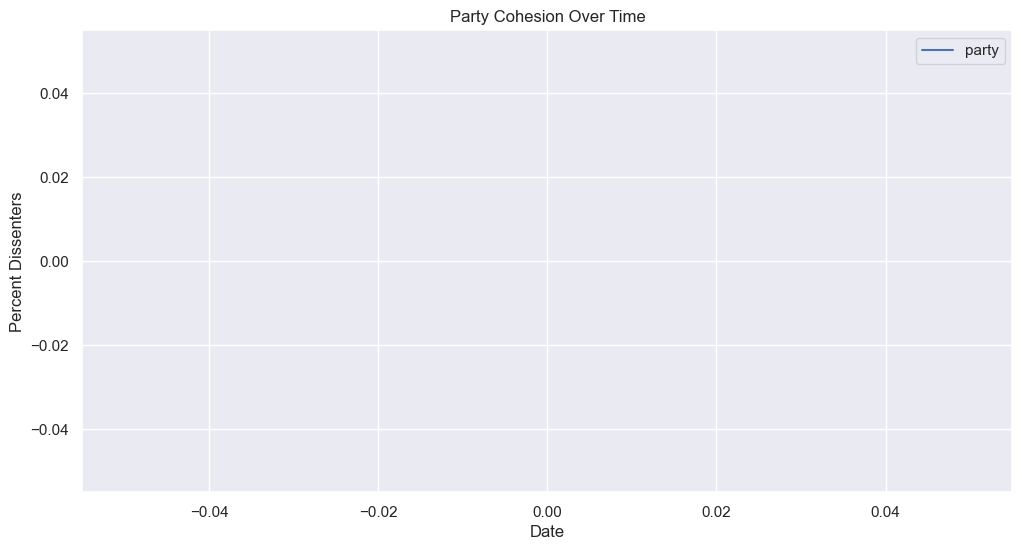

In [81]:
sns.set_theme(style="darkgrid")
sns.color_palette("Set2")

df_renew = df_final[df_final['party'] == 'Renew Europe']

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_renew, x='timestamp', y='percent_dissent', label='party')

plt.xlabel('Date')
plt.ylabel('Percent Dissenters')
plt.title('Party Cohesion Over Time')
plt.legend()
plt.show()

In [87]:
df_final.to_csv('time_series_data.csv', index=False) 

In [ ]:
# logisitc regression - predicting raw percentages and then evalutating it like a linreg model
# using party and procedure type to predict percent dissent
# somethings wrong bc r2 is negative

X, y = df_final[['party', 'procedure_type']], df_final['percent_dissent']

# Convert the target variable to binary (1 for diabetes, 0 for no diabetes)
y_binary = (y > np.median(y)).astype(int)

#X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, (y_train > np.median(y)).astype(int))  # binary target for training

# Get raw predicted probabilities
#probs = model.predict_proba(X)[:, 1]  # probability of class 1
probs_test = model.predict_proba(X_test)[:, 1] * 100
mse_test = mean_squared_error(y_test, probs_test)
r2_test = r2_score(y_test, probs_test)

# If you want as a percent:
#percent_probs = probs * 100
# Step 6: Predict probabilities as continuous outcome
probs_train = model.predict_proba(X_train_scaled)[:, 1] * 100
probs_test = model.predict_proba(X_test_scaled)[:, 1] * 100

# Step 7: Evaluate as regression
mse_train = mean_squared_error(y_train, probs_train)
mse_test = mean_squared_error(y_test, probs_test)
r2_train = r2_score(y_train, probs_train)
r2_test = r2_score(y_test, probs_test)

print("TRAIN MSE:", mse_train, "R²:", r2_train)
print("TEST  MSE:", mse_test, "R²:", r2_test)
# prints predicted dissents - now we have to compare them to the actual
#percent_probs

# Evaluate the predicted percent probabilities against the actual percent_dissent
#mse = mean_squared_error(y, percent_probs)
#mae = mean_absolute_error(y, percent_probs)
#r2 = r2_score(y, percent_probs)

TRAIN MSE: 3437.987846303271 R²: -127514.6221669875
TEST  MSE: 3321.8937841097445 R²: -116333.30475151881


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [89]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
# 1. Define features and target
X = df_final[['party', 'procedure_type']]
y_continuous = df_final['percent_dissent']  # for inspection
y_binary = (y_continuous > y_continuous.median()).astype(int)  # binary target for logistic regression

# 2. One-hot encode categoricals
X_encoded = pd.get_dummies(X)

# 3. Train-test split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_encoded, y_binary, test_size=0.2, random_state=42)

# 4. Standardize (optional but okay for LR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train_bin)

# 6. Predict probabilities (for class 1 = high dissent)
probs_train = model.predict_proba(X_train_scaled)[:, 1]
probs_test = model.predict_proba(X_test_scaled)[:, 1]

# 7. Evaluate using binary metrics (not regression)
print("TRAIN Accuracy:", accuracy_score(y_train_bin, probs_train > 0.5))
print("TEST  Accuracy:", accuracy_score(y_test_bin, probs_test > 0.5))

print("TRAIN AUC:", roc_auc_score(y_train_bin, probs_train))
print("TEST  AUC:", roc_auc_score(y_test_bin, probs_test))

print("TRAIN MSE (to probability):", mean_squared_error(y_train_bin, probs_train))
print("TEST  MSE (to probability):", mean_squared_error(y_test_bin, probs_test))

TRAIN Accuracy: 0.7853806228373702
TEST  Accuracy: 0.7945347630577655
TRAIN AUC: 0.8484642600574713
TEST  AUC: 0.8597075136506076
TRAIN MSE (to probability): 0.15601616612873076
TEST  MSE (to probability): 0.14953104439489698


In [ ]:
# using party and time metrics to predict percent dissent
# r2 is low but its fine

#df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])  # Ensure correct type
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], format='ISO8601', errors='coerce')

# Extract useful time-based features
df_final['year'] = df_final['timestamp'].dt.year
df_final['month'] = df_final['timestamp'].dt.month
df_final['quarter'] = df_final['timestamp'].dt.to_period('Q').astype(str)  # e.g., '2022Q1'

X = df_final[['party', 'year', 'month', 'quarter']]
y = df_final['percent_dissent']

# One-hot encode all categorical features (party, procedure_type, quarter)
X_encoded = pd.get_dummies(X, columns=['party', 'quarter'], drop_first=True)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 4: Feature scaling (optional but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Step 6: Predict and evaluate
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("TRAIN MSE:", mse_train, "R²:", r2_train)
print("TEST  MSE:", mse_test, "R²:", r2_test)

TRAIN MSE: 0.0169173751511893 R²: 0.3725313426701554
TEST  MSE: 0.01719562111006546 R²: 0.39780114699058133


In [ ]:
#  random forest model
# r2 is worse than the linear regression... but can i use that? try to fix logistic one to be the same r2 as linreg

# 1. Feature engineering (make sure timestamp is datetime)
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], format='ISO8601', errors='coerce')
df_final['year'] = df_final['timestamp'].dt.year
df_final['month'] = df_final['timestamp'].dt.month
df_final['quarter'] = df_final['timestamp'].dt.to_period('Q').astype(str)
df_final['time_index'] = df_final['timestamp'].rank(method='first')  # numeric trend

# 2. Define X and y
X = df_final[['party', 'year', 'month', 'quarter', 'time_index']]
y = df_final['percent_dissent']

# 3. One-hot encode categoricals
X_encoded = pd.get_dummies(X, columns=['party', 'quarter'], drop_first=True)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. No need to scale for RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Predictions + evaluation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("TRAIN MSE:", mse_train, "R²:", r2_train)
print("TEST  MSE:", mse_test, "R²:", r2_test)


TRAIN MSE: 0.002820698989160326 R²: 0.8953797387808324
TEST  MSE: 0.02099775281577109 R²: 0.26464868116738216


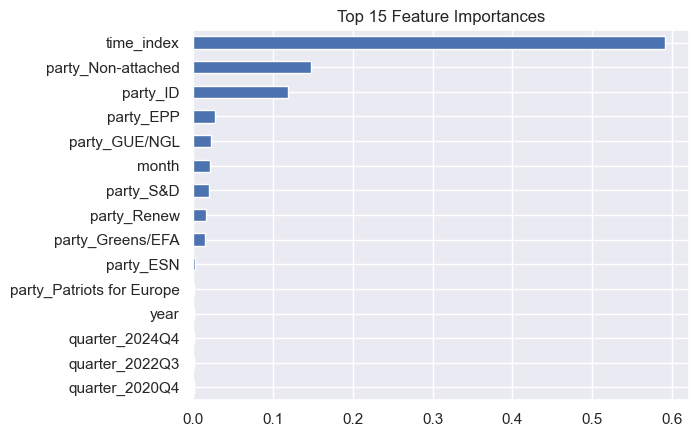

In [86]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X_encoded.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()